In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
library(tidyr)
library(ggrepel)

# read switches
candidateInfo <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    mutate(Coocurrent= ifelse(is.na(Coocurrent),FALSE,Coocurrent),
           Candidate = as.logical(Recurrent) | as.logical(AffectingMutatedFeature) | as.logical(Coocurrent)) %>%
    mutate(Candidate = revalue(as.character(Candidate),replace=c("TRUE"="Candidate","FALSE"="Non-candidate"))) %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript,Recurrent,AffectingMutatedFeature,Coocurrent,Candidate)

switches <- read_tsv("../data/pancancer/candidateList_info.tumorSplit.tsv")
switches.agg <- read_tsv("../data/pancancer/candidateList_info.agg.tsv")

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt")

# read interactions
ppi.file <- "../data/structural_analysis/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
         value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction!="") %>%
    # split interaction information
    separate(Interaction, into=c("What","Transcript","Pfams"), sep="-") %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches) %>%
    merge(candidateInfo) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome,by.x=c("Tumor","Transcript"), by.y=c("Cancer","Transcript"), suffixes = c(".switch",".partner"))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract

Warning message:
: attributes are not identical across measure variables; they will be dropped

* Control for expression

* Check genesets in interesting genes (cantdidates & potus)

# Trends across categories

We will check if the bulk of interactions tend to involve a switch in a particular set of genes eg drivers. We know that drivers, for several reasons, will have more interactions. However, a comparison between the proportions of "Kept" interactions and "Gained"/"Lost" should reveal differential behaviour.

In [2]:
# overview of data frame
head(ppi)

,Tumor,Transcript,GeneId,Symbol.switch,Normal_transcript,Tumor_transcript,partnerId,partnerSymbol,What,Normal_protein,Tumor_protein,Annotation,DriverAnnotation,NotNoise,IsModel,IsFunctional,Driver,SpecificDriver,Druggable,CDS_Normal,CDS_Tumor,CDS_change,UTR_change,Patients_affected,PatientNumber,Percentage,Recurrent,AffectingMutatedFeature,Coocurrent,Candidate,Gene,Symbol.partner,TPM,ProteinLength,asEvidence
1,brca,uc001ade.2,7186,TRAF2,uc004cjv.2,uc010nbw.2,7293,TNFRSF4,Kept,Q12933,Q12933-4,HALLMARK_ALLOGRAFT_REJECTION,d1,0,0,1,0,0,0,1,1,1,0,"A03NT,A03XT",2,0.001930502,0,0,0,Non-candidate,7293,TNFRSF4,1.576145,277,True
2,brca,uc001aer.3,4088,SMAD3,uc010ujs.1,uc010ujt.1,1855,DVL1,Kept,P84022-2,P84022-4,HALLMARK_TGF_BETA_SIGNALING,driver,1,0,1,1,0,0,1,1,1,1,"A2DAT,A66OT,A576T,A1LAT,A42UT,A1J6T,A1LST,A56ZT",8,0.007722008,1,0,0,Candidate,1855,DVL1,18.54956,670,True
3,brca,uc001aer.3,1453,CSNK1D,uc002keg.1,uc002kei.2,1855,DVL1,Gained,None,P48730-2,HALLMARK_MITOTIC_SPINDLE,d1,1,1,1,0,0,0,0,1,1,1,"A0YMT,A0JMT,A1FMT,A0JET,A18VT,A1HJT,A1G1T,A6VOT",8,0.007722008,1,0,0,Candidate,1855,DVL1,18.54956,670,True
4,brca,uc001aer.3,1454,CSNK1E,uc003avk.2,uc003avq.1,1855,DVL1,Kept,P49674,None,HALLMARK_WNT_BETA_CATENIN_SIGNALING,d1,1,1,1,0,0,0,1,1,1,1,"A0DST,A56DT,A06OT,A092T,A24UT",5,0.004826255,0,0,0,Non-candidate,1855,DVL1,18.54956,670,True
5,brca,uc001aer.3,4088,SMAD3,uc010ujs.1,uc010ujr.1,1855,DVL1,Kept,P84022-2,P84022-3,HALLMARK_TGF_BETA_SIGNALING,driver,1,1,1,1,0,0,1,1,1,1,"A1XJT,A3KDT,A26VT,A1LBT,A08PT,A3XTT,A0BST,A0YGT,A049T,A0X1T,A0E7T",11,0.01061776,0,0,0,Non-candidate,1855,DVL1,18.54956,670,True
6,brca,uc001aer.3,4087,SMAD2,uc010xdd.1,uc002lcy.2,1855,DVL1,Kept,None,Q15796,HALLMARK_PI3K_AKT_MTOR_SIGNALING,driver,0,1,1,1,0,1,1,1,1,1,"A1J6T,A54NT,A0JLT,A0FTT",4,0.003861004,0,0,0,Non-candidate,1855,DVL1,18.54956,670,True


## Drivers

### Tumor specific


	Pearson's Chi-squared test

data:  .
X-squared = 121.48, df = 2, p-value < 2.2e-16


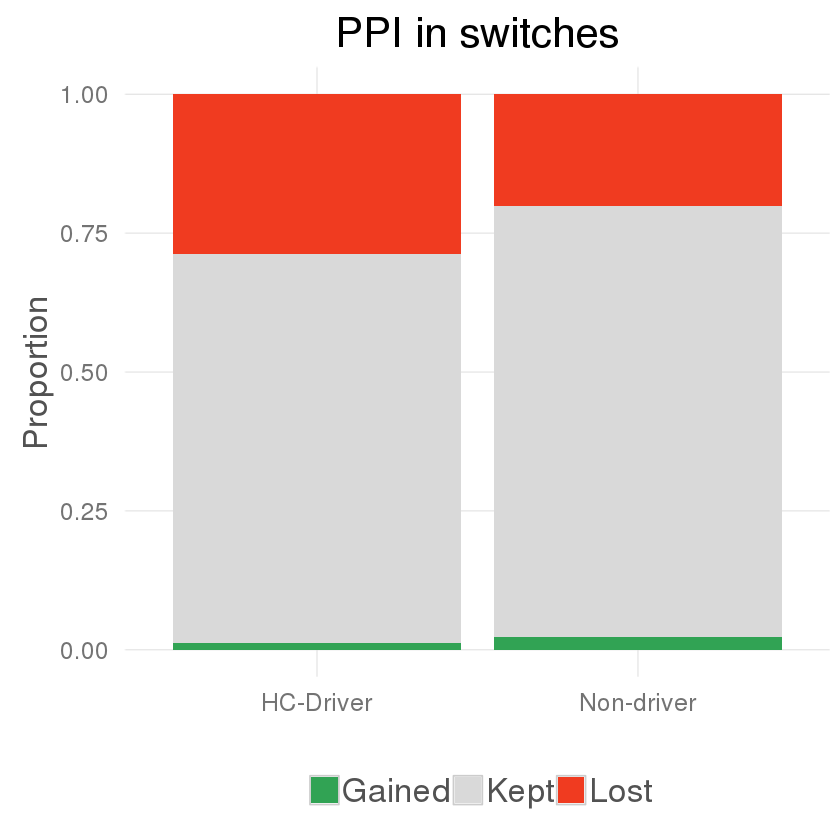

In [3]:
ggplot(ppi,aes(x=revalue(as.character(SpecificDriver),replace=c("1"="HC-Driver","0"="Non-driver")),fill=What)) + 
    geom_bar(position="fill") +
    smartas_theme() +
    labs(x="",y="Proportion",fill="",title="PPI in switches") +
    scale_fill_manual(values = c("Gained" = "#31a354", "Lost" = "#f03b20", "Kept" = "#d9d9d9")) +
    theme(legend.position="bottom")

ppi %>%
    select(SpecificDriver,What) %>%
    table %>%
    chisq.test

The proportion of gained, lost and kept interactions changes from drivers to non-drivers. Drivers (only specific drivers used) tend to lose more interactions and to gain less.

### Potential drivers


	Pearson's Chi-squared test

data:  .
X-squared = 249.22, df = 2, p-value < 2.2e-16


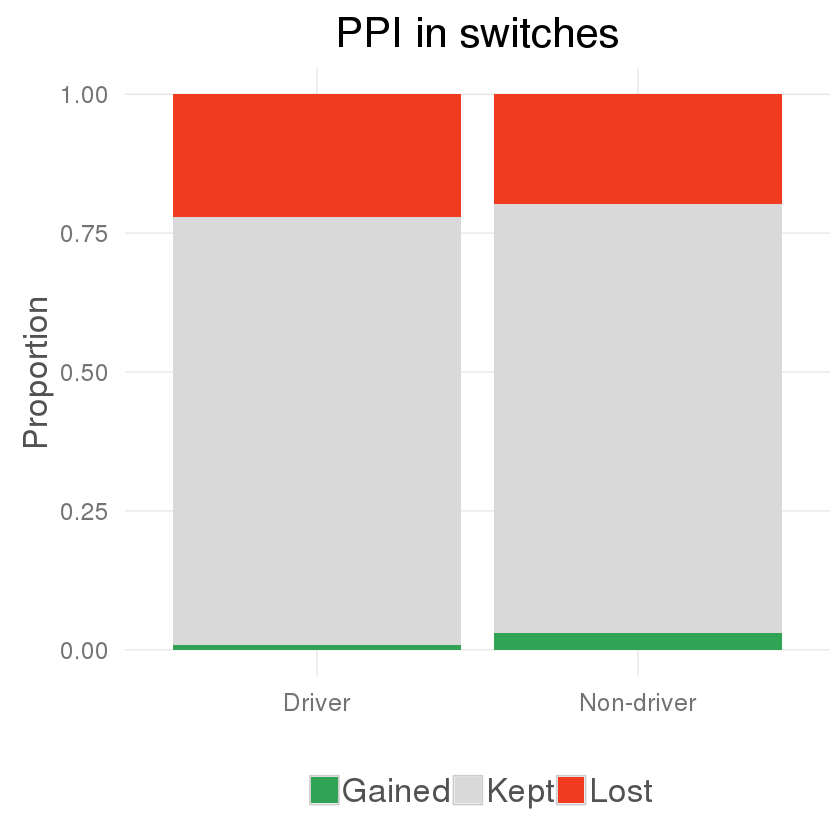

In [4]:
ggplot(ppi,aes(x=revalue(as.character(Driver),replace=c("1"="Driver","0"="Non-driver")),fill=What)) + 
    geom_bar(position="fill") +
    smartas_theme() +
    labs(x="",y="Proportion",fill="",title="PPI in switches") +
    scale_fill_manual(values = c("Gained" = "#31a354", "Lost" = "#f03b20", "Kept" = "#d9d9d9")) +
    theme(legend.position="bottom")

ppi %>%
    select(Driver,What) %>%
    table %>%
    chisq.test

The same goes for the list of potential drivers: the enrichment is still there. However, it looks weaker. The signal is strong in the well curated set of drivers, and when adding potential drivers we are adding some noise.

## Candidate switches

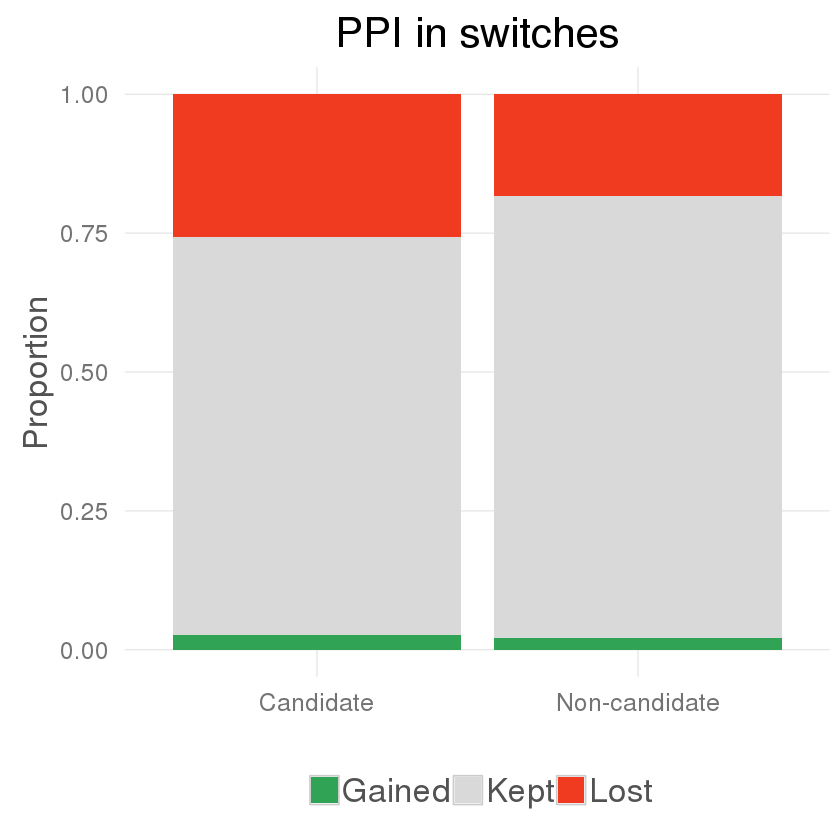


	Pearson's Chi-squared test

data:  .
X-squared = 405.4, df = 2, p-value < 2.2e-16


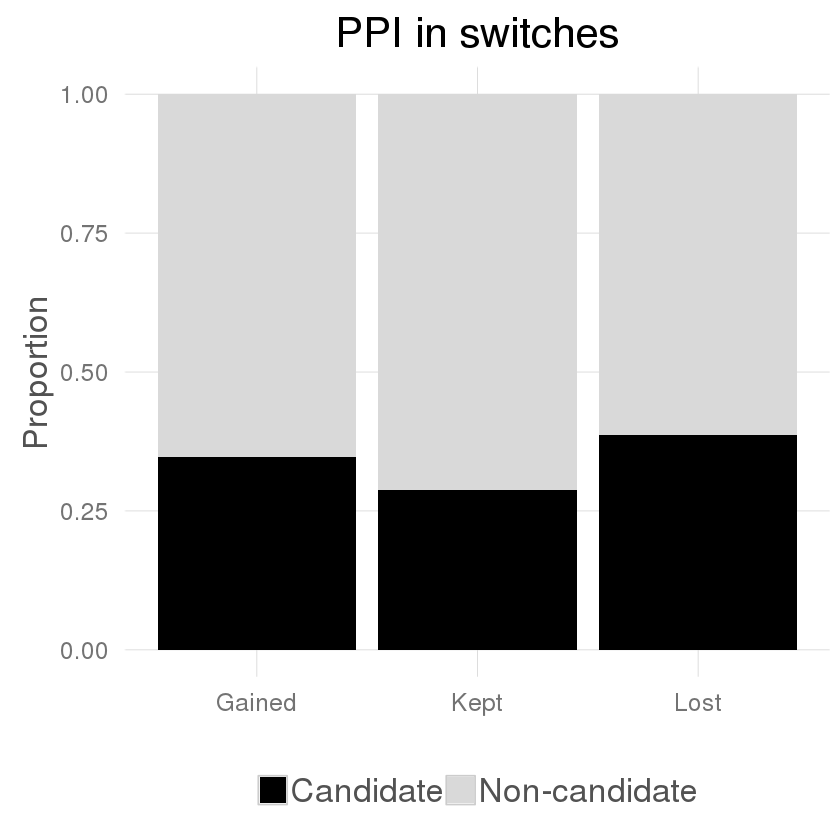

In [5]:
ggplot(ppi,aes(x=Candidate,fill=What)) + 
    geom_bar(position="fill") +
    smartas_theme() +
    labs(x="",y="Proportion",fill="",title="PPI in switches") +
    scale_fill_manual(values = c("Gained" = "#31a354", "Lost" = "#f03b20", "Kept" = "#d9d9d9")) +
    theme(legend.position="bottom")

ggplot(ppi,aes(x=What,fill=Candidate)) + 
    geom_bar(position="fill") +
    smartas_theme() +
    labs(x="",y="Proportion",fill="",title="PPI in switches") +
    scale_fill_manual(values=c("Candidate"="#000000", "Non-candidate"="#d9d9d9")) +
    theme(legend.position="bottom")

ppi %>%
    select(Candidate,What) %>%
    table %>%
    chisq.test

Candidates also have a different distribution of the nature of interactions. Specifically, it seems that tend to keep interactions less, and both to gain and lose more.

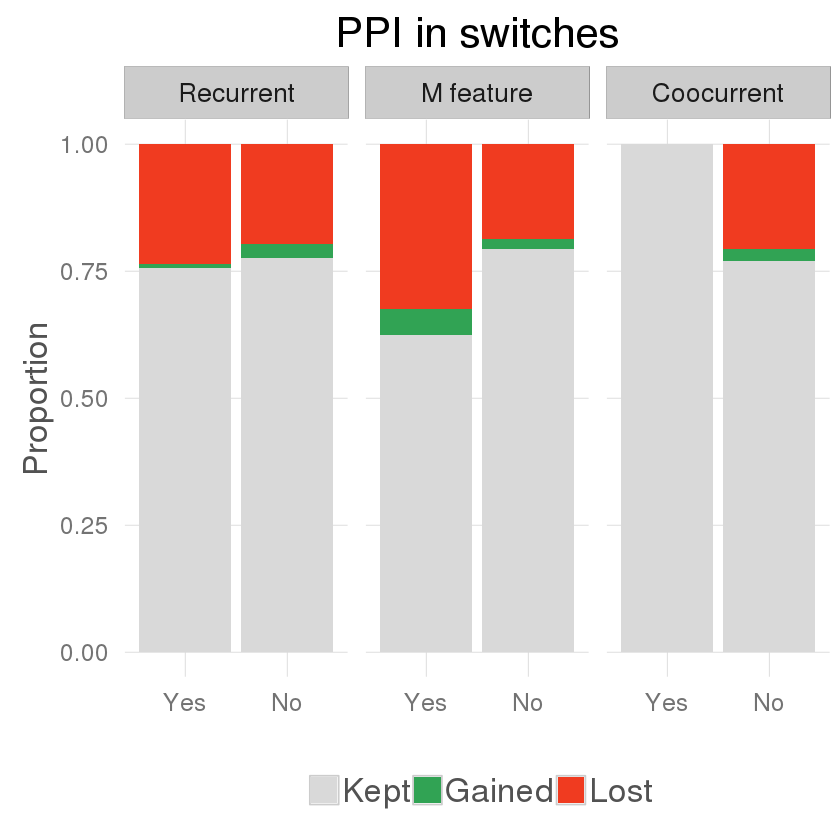

In [6]:
ppi %>%
    select(What,Recurrent,AffectingMutatedFeature,Coocurrent) %>%
    # convert to long format and reannotate the columns
    melt(id.vars = "What",variable.name = "Indication", value.name = "Altered") %>%
    mutate(Altered=ifelse(Altered==1,"Yes","No"),
           Altered=factor(Altered, levels=c("Yes","No")),
           What=factor(What,levels=c("Kept","Gained","Lost")),
           Indication=revalue(Indication, replace = c("AffectingMutatedFeature"="M feature"))) %>%
    # plot
    ggplot(aes(x = Altered, fill = What)) + 
        geom_bar(position = "fill") +
        smartas_theme() +
        labs(x = "", y = "Proportion", fill = "", title = "PPI in switches") +
        scale_fill_manual(values = c("Gained" = "#31a354", "Lost" = "#f03b20", "Kept" = "#d9d9d9")) +
        theme(legend.position = "bottom") +
        facet_grid(.~Indication)

We split the candidates by category. The most important change comes probably from the *M feature* candidates ie the candidates with domains likely to be in tumor drivers. Knowing that drivers have more interactions and are better studied, it is not surprising we are recovering this result: possibly the same domains that help drivers to become hubs allow other genes to do so. Hence, those switches are enriched both in gains and losses.

Recurrent switches do not have this bias though. We observe how they also tend to lose more interactions than the rest of the switches but gain less too. This reveals their possible impact on the PPI network and gives an explanation of their recurrence.

# Switch-level analysis

Study the proportions of interactions established by switched genes that change.

In [7]:
# interactions with isoforms, not with genes
## tumor specific
ppi.switch <- ppi %>%
    group_by(Tumor,GeneId,Symbol.switch,Normal_transcript,Tumor_transcript)  %>%
    summarise(Kept=sum(What=="Kept"),Gained=sum(What=="Gained"),Lost=sum(What=="Lost")) %>%
    mutate(Total=Kept+Gained+Lost, Affected=Gained+Lost,
           Tag=paste(Tumor,Symbol.switch, Normal_transcript, Tumor_transcript, sep="-")) %>%
    # annotate with switch info
    merge(switches) %>%
    arrange(desc(Total))

## pancancer, averaging data using a median
ppi.switch.agg <- ppi.switch %>%
    group_by(GeneId,Symbol.switch,Normal_transcript,Tumor_transcript)  %>%
    summarise(Kept=median(Kept), Gained=median(Gained),Lost=median(Lost)) %>%
    mutate(Total=Kept+Gained+Lost, Affected=Gained+Lost,
           Tag=paste(Symbol.switch, Normal_transcript, Tumor_transcript, sep="-")) %>%
    # annotate with switch info
    merge(switches.agg) %>%
    arrange(desc(Total))

In [8]:
# data frame overview
head(ppi.switch.agg)

,GeneId,Normal_transcript,Tumor_transcript,Symbol.switch,Kept,Gained,Lost,Total,Affected,Tag,Symbol,Normal_protein,Tumor_protein,DriverAnnotation,NotNoise,IsModel,IsFunctional,Driver,Druggable,CDS_Normal,CDS_Tumor,CDS_change,UTR_change,Tumors,PatientNumber,Percentage,Patients_affected
1,2885,uc002jnx.3,uc002jny.3,GRB2,102,0,13,115,13,GRB2-uc002jnx.3-uc002jny.3,GRB2,P62993,P62993-2,d1,1,1,1,0,0,1,1,1,0,"brca,hnsc,kirc,kirp,lihc,prad,thca",38,0.008554705,"A572T,A54OT,A3X8T,A6FRT,A574T,A45QT,A6EPT,5185T,A854T,A47NT,A39VT,5259T,A119T,A3A7T,A4ZPT,A73GT,A46FT,6379T,A67QT,A6ILT,A6HXT,A6INT,A67OT,7325T,A6IOT,A6IMT,A7AWT,A4UBT,A2QAT,A22QT,A3D1T,A2CRT,A4MAT,A4KNT,A4I1T,A3ZQT,A41FT,A3PAT"
2,1017,uc001sit.3,uc010spy.1,CDK2,70,0,0,70,0,CDK2-uc001sit.3-uc010spy.1,CDK2,P24941,None,d1,1,1,1,0,0,1,1,1,0,"brca,kirc,kirp,lihc,thca",10,0.002251238,"A3TMT,A3XVT,A54OT,4841T,4842T,4642T,A7VFT,A5DJT,A495T,A4MAT"
3,6464,uc001ffx.2,uc001ffu.2,SHC1,58,0,1,59,1,SHC1-uc001ffx.2-uc001ffu.2,SHC1,P29353-7,None,d1,1,1,1,0,0,1,1,1,1,"coad,kich,kirc,kirp,prad",50,0.01125619,"5344T,5540T,5349T,4616T,A282T,4743T,5256T,A280T,6317T,A0XDT,6298T,6166T,6320T,8327T,8476T,4875T,4146T,4847T,5989T,5832T,5886T,A55ZT,3472T,3471T,A5EAT,A654T,4114T,A854T,A6M8T,A7VFT,A59TT,4115T,A83VT,A5NIT,A6HPT,A898T,A562T,A71RT,A47NT,A6M9T,A67QT,A7AWT,A6HXT,6347T,A6ILT,A46FT,6379T,A6INT,A67OT,A6IMT"
4,2064,uc002hso.2,uc010wek.1,ERBB2,57.5,0,0,57.5,0,ERBB2-uc002hso.2-uc010wek.1,ERBB2,P04626,None,driver,1,1,1,1,1,1,1,1,0,"brca,kich,kirp,luad",102,0.02296263,"A10CT,A423T,A6FRT,A0I1T,A0JBT,A54NT,A572T,A3NYT,A3X8T,A0IAT,A0IET,A0J9T,A0HAT,A131T,A56DT,A3XUT,A2DBT,A0CQT,A66LT,A1B6T,A3TMT,A1KRT,A04UT,A03NT,A54OT,A2DOT,A1J6T,A7HQT,A03TT,A04PT,A5FKT,A0CRT,A5YLT,A2DDT,A574T,A126T,A2QJT,A0E6T,A5FLT,A12YT,A2FST,8409T,8415T,8327T,8476T,4617T,5881T,7287T,A5DUT,5888T,A5NIT,7837T,A59TT,7834T,A562T,A854T,A6M8T,7841T,7836T,7173T,A5Z9T,A898T,5561T,A5DJT,A4TMT,6720T,A74VT,A856T,A5NLT,A7VFT,A5E6T,7045T,5885T,7732T,A83VT,5887T,A7SNT,A40UT,6796T,A6HPT,A47NT,A71WT,A6GET,7725T,7813T,A44FT,A4EZT,5375T,7499T,8028T,1678T,7166T,4507T,7727T,A4BDT,8672T,1676T,A4VPT,5051T,5045T,1677T,4514T"
5,2534,uc003pvj.2,uc003pvh.2,FYN,53.5,0,0,53.5,0,FYN-uc003pvj.2-uc003pvh.2,FYN,P06241,P06241-2,driver,1,1,1,1,0,1,1,1,1,"brca,kirc,kirp,luad",57,0.01283206,"A1AWT,A0CRT,A1B6T,A1IZT,A128T,A14NT,A2FBT,A1J6T,A12VT,A18HT,A129T,A0B6T,A1PBT,A22DT,A1IIT,A0IJT,A66PT,A0H5T,A2JTT,A08IT,A6SBT,A5FKT,A0U0T,A0C0T,A0B9T,A3XZT,A04QT,A1KQT,A2DOT,A3ZXT,A3QAT,A2DDT,A5YNT,A0EQT,A66UT,A25FT,A1OVT,A66IT,A3Y0T,A1HMT,A5DET,A0TTT,A5QQT,A2DIT,A0RTT,A73UT,A1B5T,A10CT,A6IWT,A0CLT,A0STT,A5D7T,A5YOT,4817T,A5NLT,8660T,A46UT"
6,1457,uc002wdx.1,uc002wdy.1,CSNK2A1,50,0,0,50,0,CSNK2A1-uc002wdx.1-uc002wdy.1,CSNK2A1,P68400,P68400-2,driver,1,1,1,1,0,1,1,1,1,"coad,hnsc,kich,kirp,lusc,thca",47,0.01058082,"4743T,A0XDT,A1D0T,A280T,A6JMT,A6IJT,6436T,A45TT,A49BT,7269T,A6IHT,A6JNT,A622T,A6DAT,A45QT,A461T,A6JET,A6IIT,A6H7T,4224T,7870T,A6K1T,A5Q6T,A6EST,A6EMT,A6EPT,5973T,7871T,A634T,A6D8T,A5QFT,8327T,8408T,5885T,7173T,A40UT,6796T,A59TT,A5NKT,4617T,A5NIT,A7VFT,A47OT,4135T,4130T,2726T,A41JT"


## General

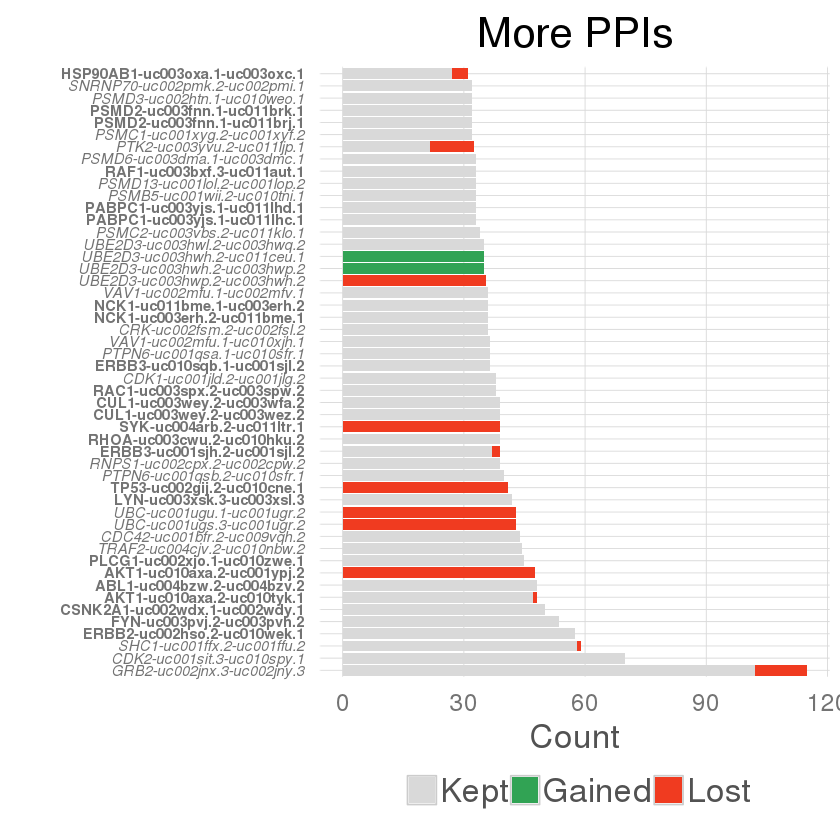

In [9]:
# check the switched genes with more studied ppis
top.ppis <- ppi.switch.agg %>%
    head(n = 50) %>%
    select(Tag,Driver,Kept,Gained,Lost) %>%
    melt(id.vars = c("Tag","Driver")) %>%
    mutate(Tag = factor(Tag, levels = unique(Tag)))

ggplot(top.ppis, aes(x = Tag, y = value, fill = variable)) + 
    geom_bar(stat="identity") +
    scale_fill_manual(values = c("Gained" = "#31a354", "Lost" = "#f03b20", "Kept" = "#d9d9d9")) +
    smartas_theme() +
    labs(title = "More PPIs", x = "", y = "Count", fill = "") +
    theme(axis.text.y = element_text(size = 9, face=ifelse(top.ppis$Driver==1,"bold","italic")), 
          legend.position = "bottom") +
    coord_flip()

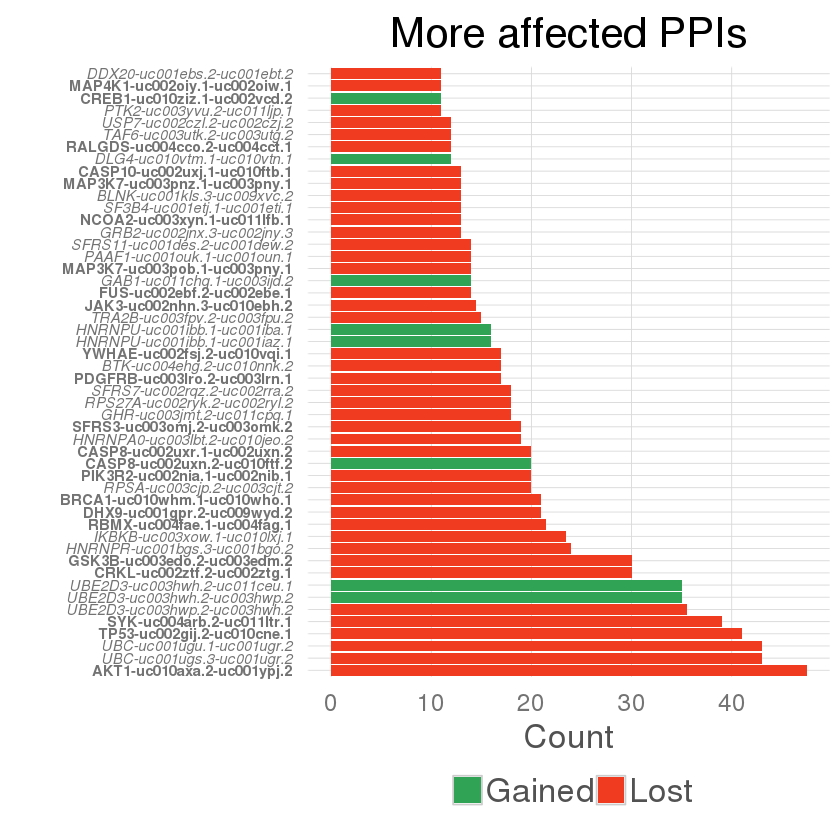

In [10]:
top.altered.ppis <- ppi.switch.agg %>%
    arrange(desc(Affected)) %>%
    head(n = 50) %>%
    select(Tag,Driver,Gained,Lost) %>%
    melt(id.vars = c("Tag","Driver")) %>%
    mutate(Tag=factor(Tag,levels=unique(Tag)))

ggplot(top.altered.ppis, aes(x=Tag,y=value,fill=variable)) + 
    geom_bar(stat="identity") +
    scale_fill_manual(values = c("Gained" = "#31a354", "Lost" = "#f03b20", "Kept" = "#d9d9d9")) +
    smartas_theme() +
    labs(title = "More affected PPIs", x = "", y = "Count", fill = "") +
    theme(axis.text.y = element_text(size = 9, face=ifelse(top.altered.ppis$Driver==1,"bold","italic")), 
          legend.position = "bottom") +
    coord_flip()

In **bold**, driver genes; the others are in *italic*.

In [11]:
ppi.switch.agg %>%
    mutate(VeryAffected=Affected/Total > 0.5) %>%
    select(Driver,VeryAffected) %>%
    table %>%
    fisher.test


	Fisher's Exact Test for Count Data

data:  .
p-value = 0.4964
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.730192 1.160114
sample estimates:
odds ratio 
 0.9222736 


## Driver interactors

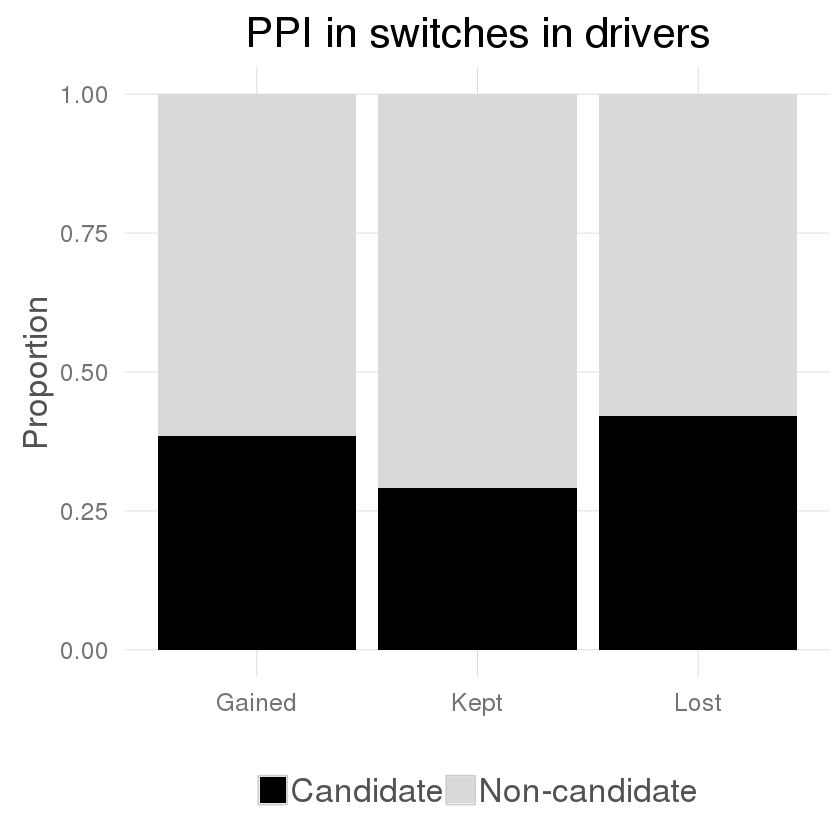

In [12]:
# read drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#")

# study interactions with high confidence cancer-drivers
ppi.wDrivers <- merge(ppi,drivers,by.x="partnerSymbol",by.y="geneHGNCsymbol")

ppi.wDrivers %>%
    ggplot(aes(x=What,fill=Candidate)) + 
    geom_bar(position="fill") +
    smartas_theme() +
    labs(x="",y="Proportion",fill="",title="PPI in switches in drivers") +
    scale_fill_manual(values=c("Candidate"="#000000", "Non-candidate"="#d9d9d9")) +
    theme(legend.position="bottom")

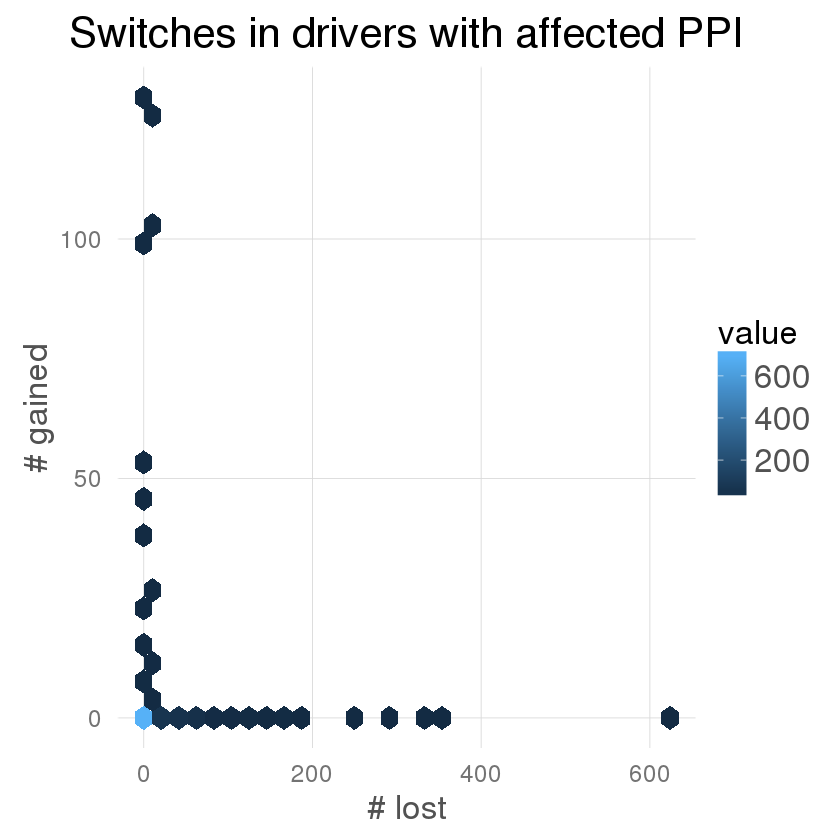

In [13]:
ppi.wDrivers %>%
    group_by(GeneId,Symbol.switch,Normal_transcript,Tumor_transcript) %>%
    summarise(Kept=sum(What=="Kept"),Gained=sum(What=="Gained"),Lost=sum(What=="Lost")) %>%
    ggplot(aes(x=Lost,y=Gained)) + 
        stat_binhex() +
        smartas_theme() +
        labs(title="Switches in drivers with affected PPI", x="# lost", y="# gained") +
        theme(legend.position="right")

## PoTuS

In [14]:
# read genesets
gs.file <- "../data/genesets/c2.cp.v4.0.entrez.gmt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(gs.file,sep = "\t"))

gs <- read.table(gs.file,header=F,fill=T,col.names=1:no_col) %>%
            .[,-2]
gsNames <- gs$X1

# convert to list of character vectors
gs <- apply(gs,1,function(x){ 
    as.character(x[2:length(x)][!is.na(x[2:length(x)])]) 
})
names(gs) <- gsNames

# read potus
ppi.potus <- read_tsv("../results/potus.tsv") %>%
    mutate(potus="potus") %>%
    merge(ppi,all.y=T) %>%
    mutate(potus=ifelse(is.na(potus),"non-potus",potus))

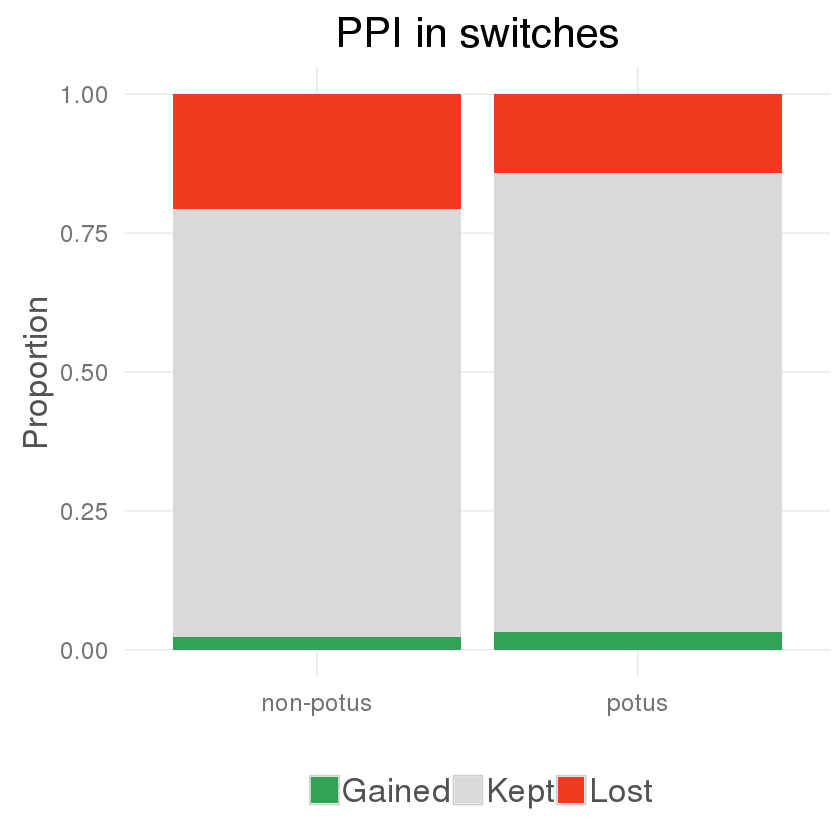

In [15]:
ggplot(ppi.potus,aes(x=potus,fill=What)) + 
    geom_bar(position="fill") +
    smartas_theme() +
    labs(x = "", y = "Proportion", fill = "", title = "PPI in switches") +
    scale_fill_manual(values = c("Gained" = "#31a354", "Lost" = "#f03b20", "Kept" = "#d9d9d9")) +
    theme(legend.position = "bottom")

In [16]:
ppi.onlypotus.d <- read_tsv("../results/potus.meDrivers.tsv") %>%
    merge(ppi)

same.pw <- function(pathways,partnerId){
    pathways <- pathways %>% strsplit(",") %>% unlist
    
    for (pw in pathways) {
        if (partnerId %in% gs[[pw]])
            return("Yes")
        }
    
    return("No")
}

df <- ddply(ppi.onlypotus.d,.(GeneId,Normal_transcript,Tumor_transcript,
                              partnerId,partnerSymbol,DriverSymbol,Pathway), 
            transform, AffectedPw = same.pw(Pathway,partnerId) )
    
df %>%
    select(GeneId,Symbol.switch,Normal_transcript,Tumor_transcript,partnerId,partnerSymbol,DriverSymbol,Pathway,AffectedPw) %>%
    filter(AffectedPw=="Yes")

,GeneId,Symbol.switch,Normal_transcript,Tumor_transcript,partnerId,partnerSymbol,DriverSymbol,Pathway,AffectedPw
1,4690,NCK1,uc011bme.1,uc003erh.2,6654,SOS1,CASP8,REACTOME_IMMUNE_SYSTEM,Yes


# Genes whose PPI are frequently altered by switches

We want to find out if some genes tend to be affected through changes in its partners. Hence, we will look for the most frequent interaction partners among the switches, particularly those hubs for which a high proportion of the described interactions are altered (either gained or lost).

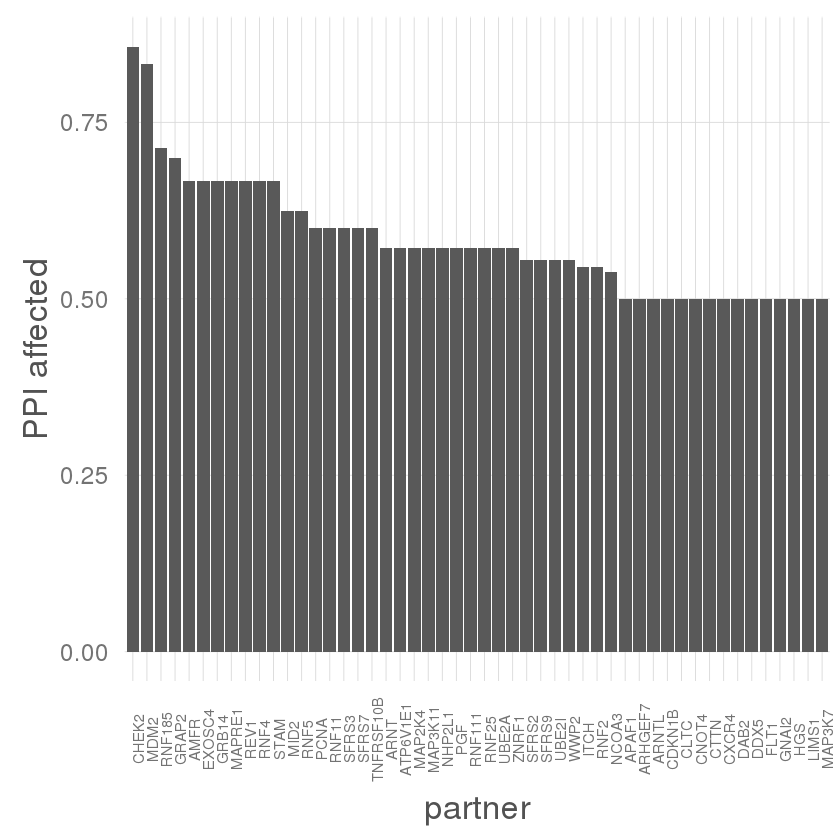

In [17]:
partners.twoOrMore <- ppi %>%
    # select unique switches affecting an interaction
    select(GeneId,Normal_transcript,Tumor_transcript,What,partnerSymbol) %>%
    unique %>%
    select(What,partnerSymbol) %>%
    # remove partners that are only affected by one switch
    subset((duplicated(What) | duplicated(What, fromLast=TRUE)) & 
           (duplicated(partnerSymbol) | duplicated(partnerSymbol, fromLast=TRUE))) %>%
    table

affected <- colSums(partners.twoOrMore[rownames(partners.twoOrMore) %in% c("Gained","Lost"),])
all <- colSums(partners.twoOrMore)

# consider only hubs
min.ppi <- 5
affected <- affected[all > min.ppi]
all <- all[all > min.ppi]

# order by higher proportion of changes to the interactions
partners.highFreq <- (affected/all)[order(affected/all, decreasing=TRUE)] %>%
    as.data.frame %>%
    set_colnames("proportionAffectedInteractions") %>%
    mutate(., partner = factor(rownames(.), levels = rownames(.)) ) %>%
    arrange(desc(proportionAffectedInteractions)) 

ggplot(partners.highFreq[1:50,], aes(x=partner, y=proportionAffectedInteractions)) +
    geom_bar(stat="identity") +
    labs(y = "PPI affected") +
    smartas_theme() +
    theme(axis.text.x=element_text(angle=90,size=9))

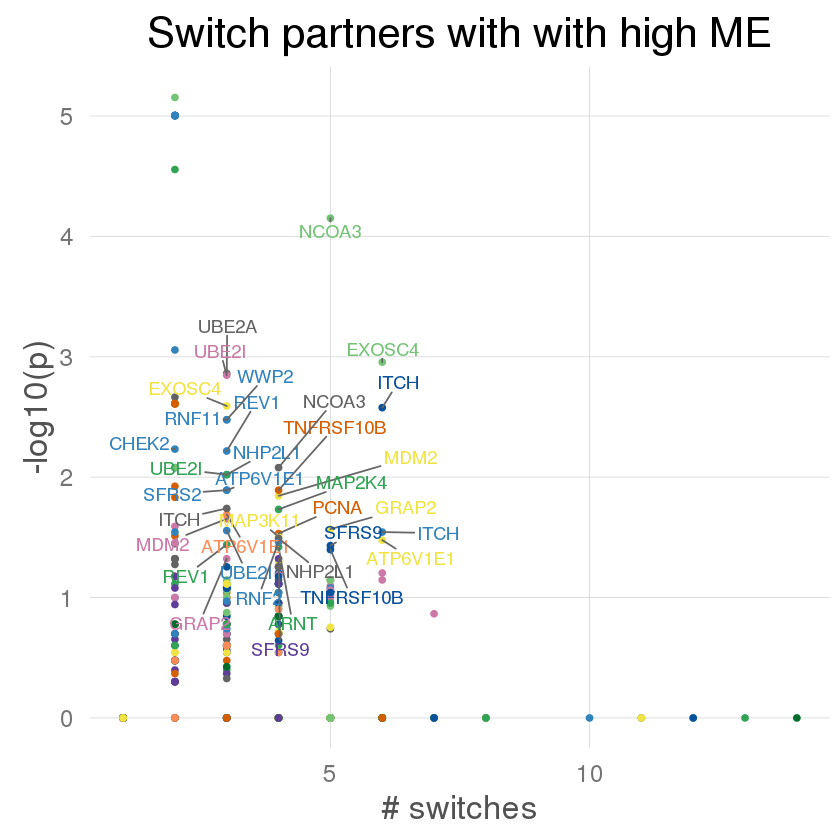

In [18]:
# calculate a p.value for a set of genes as the maximum fisher's test p
# between each gene and the others aggregated
gs.pvalue <- function(x){
    patients <- strsplit(x,",")

    p <- c()
    for (i in 1:length(patients)){
        this.switch <- patients[[i]]
        others <- unique(unlist(patients[-i]))
        
        # contingency table
        a <- length(intersect(this.switch,others))
        b <- length(this.switch) - a
        c <- length(others) - a
        d <- length(unique(unlist(patients))) - (a+b+c)
            
        p <- c(p,fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2), alternative="less")$p.value)
    }
    return(max(p))
}

# measure mutual exclusion between all the involved interactors 
# of the genes where more than 50% of the interactions change
me.ppis <- list()

for (x in partners.highFreq$partner[partners.highFreq$proportionAffectedInteractions > 0.5]){
    me.ppis[[x]] <- ppi %>%
        filter(partnerSymbol==x) %>%
        select(Tumor,partnerSymbol,GeneId,Symbol.switch,Normal_transcript,Tumor_transcript,Patients_affected) %>%
        group_by(Tumor,partnerSymbol) %>%
        summarise(p=gs.pvalue(Patients_affected),n=length(Tumor))
}

me.ppis <- do.call("rbind",me.ppis)

ggplot() +
    geom_point(data = me.ppis,aes(x=n,y=-log10(p),color=Tumor)) +
    geom_text_repel(data = subset(me.ppis, (p < 0.05 & partnerSymbol %in% drivers$geneHGNCsymbol) | (p < 0.05 & n > 2)), 
               aes(x = n, y = -log10(p), color = Tumor, label = partnerSymbol)) +
    smartas_theme() +
    labs(x="# switches", title="Switch partners with with high ME") +
    scale_color_manual(values=colorPalette)

The most interesting cases are those that are significant and involve more than two switches. If the partner is highly reliable driver, it is even better. All those cases are highlighted. 

In [19]:
# significant
## at least three switches
me.ppis$partnerSymbol[me.ppis$p<0.05 & me.ppis$n >= 3] %>%
    unique

## involving a high-confidence driver
me.ppis$partnerSymbol[me.ppis$p<0.05 & me.ppis$partnerSymbol %in% drivers$geneHGNCsymbol] %>%
    unique

[1] MDM2      GRAP2     EXOSC4    REV1      PCNA      RNF11     TNFRSF10B
 [8] ARNT      ATP6V1E1  MAP2K4    MAP3K11   NHP2L1    UBE2A     SFRS2    
[15] SFRS9     UBE2I     WWP2      ITCH      RNF2      NCOA3    
5934 Levels: A1CF A2BP1 A2M AAK1 AANAT AARS AASDHPPT AATF ABCB7 ABCC2 ... ZZZ3

[1] CHEK2   MAP2K4  MAP3K11
5934 Levels: A1CF A2BP1 A2M AAK1 AANAT AARS AASDHPPT AATF ABCB7 ABCC2 ... ZZZ3

Another way of finding interesting cases is to look for agreement among the different tumor types.

In [20]:
me.ppis %>%
    filter(p<0.05) %>%
    select(Tumor,partnerSymbol) %>%
    table %>%
    colSums %>%
    .[.>2] %>%
    sort(decreasing=TRUE)

MDM2 ATP6V1E1    UBE2I     ITCH     RNF5    SFRS9 
       5        4        4        3        3        3

Interestingly, some of the proteins seem to relate to the metabolism of p53:

* [MDM2](https://en.wikipedia.org/wiki/Mdm2#Ubiquitination_target:_p53): represses p53 transcriptional activity.
* [UBE2I](http://www.uniprot.org/uniprot/P63279): involved in its sumoylation.
* [ITCH](http://www.genecards.org/cgi-bin/carddisp.pl?gene=ITCH): E3 ubiquitin ligase. Interacts with p63.

Additionally, it seems that the ubiquitin ligase process are very affected (RNF5,UBE2I,ITCH).